<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FEniCS Tutorial 2: solving diffusion problems in 2D

We start by loading the FEniCSx modules, exaclty as in the previous tutorial.

In [1]:
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a3d664e/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [2]:
try:
    import viskex
except ImportError:
    !pip3 install "viskex@git+https://github.com/viskex/viskex.git@f26b326"
    import viskex

In [3]:
import dolfinx.fem
import dolfinx.fem.petsc
import dolfinx.mesh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import viskex

We consider the model boundary value problem: find $u: \Omega = (0, 1)^2 \to \mathbb{R}$ such that

\begin{equation*}
\begin{cases}
- \Delta u = f, & \text{in } \Omega,\\
u = g, & \text{on } \partial\Omega.
\end{cases}
\end{equation*}

with $f\equiv 1$ and the boundary value $g(\mathbf{x})$ given by
$$
g(\mathbf{x}) = g(x_0, x_1) = \sin(3 \pi x_0 + 1) \ \sin(3 \pi x_1 + 1).
$$


**Task 1: create a mesh.** As first example, we generate a triangular mesh of the domain $\Omega$, dividing both the horizontal and vertical sides of the square in nxm equispaced subintervals.

Similarly to 1D case, `dolfinx.mesh` provides the function `create_unit_square` for this task.

In [4]:
n = 10
m = 15
mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, m)

Let's see how many cells are in the mesh.

We store in:
* tdim: the problem dimension (2)
* fdim: the mesh scheleton entities dimension (1)
* num_cells: the number of triangles in the mesh

We can extract the num_cells information as we did in the 1D case from the connectivity or directly...

In [5]:
tdim = mesh.topology.dim
fdim = tdim - 1

connectivity_cells_to_vertices = mesh.topology.connectivity(mesh.topology.dim, 0)
print(connectivity_cells_to_vertices)

num_cells = len(connectivity_cells_to_vertices)
print(num_cells)

num_cells = mesh.topology.index_map(tdim).size_local
print(num_cells)

<AdjacencyList> with 300 nodes
  0: [0 1 2 ]
  1: [0 3 2 ]
  2: [4 0 3 ]
  3: [3 2 5 ]
  4: [4 6 3 ]
  5: [3 7 5 ]
  6: [8 4 6 ]
  7: [6 3 7 ]
  8: [7 5 9 ]
  9: [8 10 6 ]
  10: [6 11 7 ]
  11: [7 12 9 ]
  12: [13 8 10 ]
  13: [10 6 11 ]
  14: [11 7 12 ]
  15: [12 9 14 ]
  16: [13 15 10 ]
  17: [10 16 11 ]
  18: [11 17 12 ]
  19: [12 18 14 ]
  20: [19 13 15 ]
  21: [15 10 16 ]
  22: [16 11 17 ]
  23: [17 12 18 ]
  24: [18 14 20 ]
  25: [19 21 15 ]
  26: [15 22 16 ]
  27: [16 23 17 ]
  28: [17 24 18 ]
  29: [18 25 20 ]
  30: [26 19 21 ]
  31: [21 15 22 ]
  32: [22 16 23 ]
  33: [23 17 24 ]
  34: [24 18 25 ]
  35: [25 20 27 ]
  36: [26 28 21 ]
  37: [21 29 22 ]
  38: [22 30 23 ]
  39: [23 31 24 ]
  40: [24 32 25 ]
  41: [25 33 27 ]
  42: [34 26 28 ]
  43: [28 21 29 ]
  44: [29 22 30 ]
  45: [30 23 31 ]
  46: [31 24 32 ]
  47: [32 25 33 ]
  48: [33 27 35 ]
  49: [34 36 28 ]
  50: [28 37 29 ]
  51: [29 38 30 ]
  52: [30 39 31 ]
  53: [31 40 32 ]
  54: [32 41 33 ]
  55: [33 42 35 ]
  56: [4

We can obtain an interactive plot of the domain using `pyvista`. (Click on the menu: next to the dropdown that contains "Geometry 0" you may find three different representations: the domain itself, the edges of the mesh, and both overlayed.)

In [6]:
try:
    viskex.dolfinx.plot_mesh(mesh)
except ConnectionResetError as e:
    print(f"ConnectionResetError encountered: {e}. Continuing execution.")

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6154fc5550_0&reconnect=auto" class="pyvi…

**Task 2:** Determine IDs of boundary edges in view of the application of the Dirichlet boundary condition.

As in 1D case, this is obtained via the `dolfinx.mesh` `locate_entities_boundary` function. We want all edges on the boundary, but the function always requires a third input to permit the selection of parts of the boundary. As a workaround to this, we pass as third argument the function which always returns `True`.

In [7]:
boundary_entities = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.full((x.shape[1], ), True))
boundary_entities

array([  0,   3,   4,   6,  12,  14,  23,  25,  37,  39,  54,  56,  74,
        76,  97,  99, 123, 125, 152, 154, 183, 185, 187, 216, 218, 247,
       249, 278, 280, 309, 311, 339, 341, 366, 368, 390, 392, 411, 413,
       429, 431, 444, 446, 456, 458, 465, 467, 471, 473, 474], dtype=int32)

We can store the boundary entites in a `dolfinx.mesh` `MeshTags` object, and plot it using `viskex` to check this was done correctly.

In [8]:
boundaries = dolfinx.mesh.meshtags(mesh, fdim, boundary_entities, np.ones_like(boundary_entities))
viskex.dolfinx.plot_mesh_tags(mesh, boundaries, "boundaries")

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6154306c10_1&reconnect=auto" class="pyvi…

**Task 3: create FEM space.**

Define the finite element function space $V_h$ using $\mathbb{P}_1$ Lagrange elements.

This part of the code is indistinguishable from the 1D version...

In [9]:
Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", 2))

... and compute its dimension

In [10]:
Vh_dim = Vh.dofmap.index_map.size_local
Vh_dim

651

Once the FE space is at hand, we introduce ufl symbols to define the trial and test functions for our weak formulation:

In [11]:
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

**Task 4:** set up FEM system

We produce the weak formulation of the problem: find $u_h\in V_h$ such that
$$ \int_\Omega \nabla u \cdot \nabla v \ \mathrm{d} \mathbf{x} = \int_\Omega f \ v \ \mathrm{d} \mathbf{x},\qquad\forall v_h\in V_h$$
using `ufl`.

In [12]:
dx = ufl.dx
inner = ufl.inner
grad = ufl.grad
A = inner(grad(uh), grad(vh)) * dx

In [13]:
F = vh * dx

**Task 5:** set up the boundary conditions

In order to assign the boundary condition we first need to evaluate the expression of $g$ (i.e. $\sin(3 \pi x_0 + 1) \ \sin(3 \pi x_1 + 1)$ in our case) on the finite element space $V_h$. We do this by interpolation, so we define the discrete boundary condition as
$$g_h=I_h g$$

with $I_h$ the interpolation operator.

In [14]:
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1))

We then initialize a `dolfinx.fem` `dirichletbc` object, stating that the Dirichlet boundary condition should be equal to `gh` on each facet in `boundary_entities`.

In [15]:
boundary_dofs = dolfinx.fem.locate_dofs_topological(Vh, fdim, boundary_entities)
bc = dolfinx.fem.dirichletbc(gh, boundary_dofs)

**Task 6:** solve the FEM system.

As in 1D case, we have to first provide a `Function` class to store the solution of a finite element problem and then we are ready to solve the discrete problem allocating a new `LinearProblem` (which uses `PETSc`), providing as input the bilinear form `a`, the linear functional `F`, the boundary conditions `bcs`, and where to store the solution. Further solver options can also be passed to `PETSc`.

In [16]:
solution = dolfinx.fem.Function(Vh)

In [17]:
problem = dolfinx.fem.petsc.LinearProblem(
    A, F, bcs=[bc], u=solution,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
_ = problem.solve()

**Task7:** plot the solution

In [18]:
viskex.dolfinx.plot_scalar_field(solution, "u_h")

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b61539302d0_2&reconnect=auto" class="pyvi…

And here is a3D plot:

In [19]:
viskex.dolfinx.plot_scalar_field(solution, "u_h", warp_factor=0.1)

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6153931310_3&reconnect=auto" class="pyvi…

# Computing errors

To test convergence, let us consider a problem where we fix the exact solution. Find $u: \Omega \to \mathbb{R}$ such that

\begin{equation*}
\begin{cases}
- \Delta u = f, & \text{in } \Omega,\\
u = g, & \text{on } \partial\Omega,
\end{cases}
\end{equation*}
where
$$\Omega = (0, 1)^2$$
and $f$ and $g$ are chosen such that the exact solution to the strong formulation is
$$u_{\text{ex}}(x, y) = \sin(2 \pi x) \ \cos(2 \pi y).$$

Thus,
$$f := - \Delta u_{\text{ex}} = - \partial_{xx} u_{\text{ex}} - \partial_{yy} u_{\text{ex}} = 8 \pi^2 \ \sin(2 \pi x) \ \cos(2 \pi y).$$
> Furthermore, by splitting the boundary $\partial\Omega$ in the four sides of the square $\Omega$, we have
\begin{equation*}
\begin{cases}
g_1(y) = g(0, y) := u_{\text{ex}}(0, y) = 0, & \text{on } \Gamma_1 = \left\{0\right\} \times [0, 1],\\
g_2(x) = g(x, 0) := u_{\text{ex}}(x, 0) = \sin(2 \pi x), & \text{on } \Gamma_2 = [0, 1] \times \left\{0\right\},\\
g_3(y) = g(1, y) := u_{\text{ex}}(1, y) = 0, & \text{on } \Gamma_3 = \left\{1\right\} \times [0, 1],\\
g_4(y) = g(x, 1) := u_{\text{ex}}(x, 1) = \sin(2 \pi x), & \text{on } \Gamma_4 = [0, 1] \times \left\{1\right\},\\
\end{cases}
\end{equation*}

We want to generate a structured triangular mesh of the domain Ω, dividing both the horizontal and vertical sides of the square in n equispaced subintervals. The function should also locate boundaries Γ1,Γ2,Γ3 and Γ4.

We write the function unit_square_structured_mesh(n) using the builtin dolfinx.mesh.create_unit_square structured mesh generator and the boundary marking through four calls to dolfinx.mesh.locate_entities_boundary.

First we require a few more imports.

In [20]:
def unit_square_structured_mesh(n: int) -> tuple[dolfinx.mesh.Mesh, dict[int, np.ndarray]]:
    """Generate a structured mesh of the unit square, and locate its four boundaries."""
    # Generate structured mesh
    mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, n)

    # Locate boundary entities
    boundary_entities = {
        1: dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0.0)),
        2: dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, lambda x: np.isclose(x[1], 0.0)),
        3: dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, lambda x: np.isclose(x[0], 1.0)),
        4: dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, lambda x: np.isclose(x[1], 1.0))
    }

    # Collect boundary entities in a MeshTags object
    boundary_entities_unsorted = np.hstack([boundary_entities[i] for i in range(1, 5)]).astype(np.int32)
    boundary_values_unsorted = np.hstack([i * np.ones_like(boundary_entities[i]) for i in range(1, 5)]).astype(np.int32)
    boundary_entities_argsort = np.argsort(boundary_entities_unsorted)
    boundary_entities_sorted = boundary_entities_unsorted[boundary_entities_argsort]
    boundary_values_sorted = boundary_values_unsorted[boundary_entities_argsort]
    boundaries = dolfinx.mesh.meshtags(mesh, mesh.topology.dim - 1, boundary_entities_sorted, boundary_values_sorted)

    # Return
    return mesh, boundaries

We test the implementation on the case $n = 10$, visualizing the resulting mesh and boundary labels.

In [21]:
mesh_10, boundaries_10 = unit_square_structured_mesh(10)

viskex.dolfinx.plot_mesh(mesh_10)

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6153931e50_4&reconnect=auto" class="pyvi…

Next we write the function `unit_square_poisson_solve(mesh, boundaries, order)` combining the usual steps that we carry out when solving a finite element problem with FEniCS: (i) definition of a finite element space, (ii) definition of the weak form, (iii) definition of the boundary conditions, (iv) linear system assembly, and (v) linear system solve.

For the solving fase, we access the library KSP of linear system solvers from PETSc

In [22]:
def unit_square_poisson_solve(
    mesh: dolfinx.mesh.Mesh, boundaries: dict[int, np.ndarray], order: int
) -> tuple[dolfinx.fem.FunctionSpace, petsc4py.PETSc.Mat, dolfinx.fem.Function]:
    
    """Solve a Poisson problem on the unit square."""
    # Function space
    Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", order))

    # Weak form
    uh = ufl.TrialFunction(Vh)
    vh = ufl.TestFunction(Vh)
    x = ufl.SpatialCoordinate(mesh)
    f = 8 * ufl.pi**2 * ufl.sin(2 * ufl.pi * x[0]) * ufl.cos(2 * ufl.pi * x[1])
    
    dx = ufl.dx
    inner = ufl.inner
    grad = ufl.grad
    a = inner(grad(uh), grad(vh)) * dx
    F = f * vh * dx

    # Boundary conditions
    boundary_value = dolfinx.fem.Function(Vh)
    boundary_value.interpolate(lambda x: np.sin(2 * np.pi * x[0]))
    zero = dolfinx.fem.Constant(mesh, 0.0)

    boundary_dofs = {
        i: dolfinx.fem.locate_dofs_topological(
            Vh, mesh.topology.dim - 1, boundaries.indices[boundaries.values == i]) for i in range(1, 5)}

    bcs = [
        dolfinx.fem.dirichletbc(zero, boundary_dofs[1], Vh),
        dolfinx.fem.dirichletbc(boundary_value, boundary_dofs[2]),
        dolfinx.fem.dirichletbc(zero, boundary_dofs[3], Vh),
        dolfinx.fem.dirichletbc(boundary_value, boundary_dofs[4])]

    # Assemble system
    a_cpp = dolfinx.fem.form(a)
    F_cpp = dolfinx.fem.form(F)
    A = dolfinx.fem.petsc.assemble_matrix(a_cpp, bcs)
    A.assemble()
    b = dolfinx.fem.petsc.assemble_vector(F_cpp)
    dolfinx.fem.petsc.apply_lifting(b, [a_cpp], [bcs])
    dolfinx.fem.petsc.set_bc(b, bcs)

    # Solve
    solution = dolfinx.fem.Function(Vh)
    ksp = petsc4py.PETSc.KSP()
    ksp.create(mesh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("mumps")
    ksp.setFromOptions()
    ksp.solve(b, solution.x.petsc_vec)

    # Return
    return Vh, A, solution

Let's test it

In [23]:
_, A_10, solution_10 = unit_square_poisson_solve(mesh_10, boundaries_10, 1)

Finally, the main task: computing errors.

To this end, we write a function `unit_square_solution_error(mesh, solution, space)` that computes the norm of the error between a finite element solution and the exact solution to the Poisson problem on the domain $\Omega$. The first input argument `mesh` contains the mesh of $\Omega$, the second input argument `solution` contains the finite element solution, while the norm definition is derived from the third input argument `space` (if `space == 0`, the $L^2(\Omega) = H^0(\Omega)$ norm is used, while if `space == 1` the $H^1(\Omega)$ norm is used).

The function implments the following steps: (i) definition of the exact solution, (ii) computation of the difference between the finite element solution and the exact solution, (iii) representation of the square of norm of the error in `ufl`, (iv) evaluation of the square of norm of the error by assembling the `ufl` representation, and (v) application of a square root (do not forget this!) to get the error from its square.

In [24]:
def unit_square_solution_error(
    mesh: dolfinx.mesh.Mesh, solution: dolfinx.fem.Function, space: int
) -> float:
    """Compute the error between the FE solution and the exact solution."""
    # Definition of the exact solution
    x = ufl.SpatialCoordinate(mesh)
    u_ex = ufl.sin(2 * ufl.pi * x[0]) * ufl.cos(2 * ufl.pi * x[1])

    # Computation of the difference between the finite element solution and the exact solution
    diff = solution - u_ex

    # UFL representation of the square of the norm of the error depending on the input argument space
    dx = ufl.dx
    if space == 0:
        eh_squared_ufl = diff * diff * dx
    elif space == 1:
        inner = ufl.inner
        grad = ufl.grad
        eh_squared_ufl = diff * diff * dx + inner(grad(diff), grad(diff)) * dx
    else:
        raise RuntimeError("Invalid space.")

    # Evaluation of the square of the norm of the error by assembling the UFL representation
    eh_squared = dolfinx.fem.assemble_scalar(dolfinx.fem.form(eh_squared_ufl))

    # Compute the square root and return
    return np.sqrt(eh_squared)

We test the implementation on the solution we have obtained from the mesh with $n = 10$ and $\mathbb{P}^1$ finite elements.

Here is the L2 error

In [25]:
unit_square_solution_error(mesh, solution, 0)

np.float64(0.5398221030463016)

And the H1 error

In [26]:
unit_square_solution_error(mesh, solution, 1)

np.float64(5.818933075573138)

**Exercise 1:** Check the rate of convergence by running a series of experiments. (See, eg.  CP5)

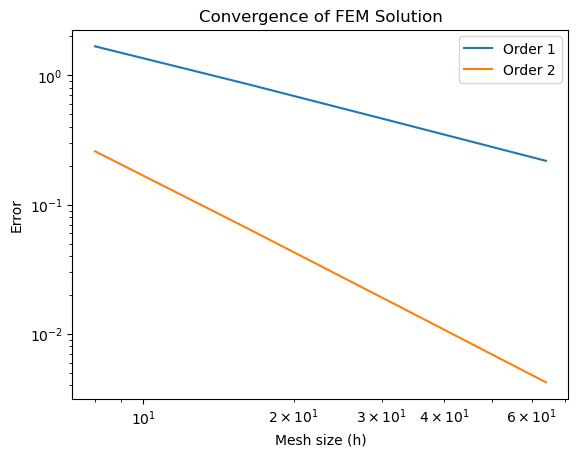

Convergence rate for order 1: -0.9817143847451311
Convergence rate for order 2: -1.9797831726306143


In [27]:
import matplotlib.pyplot as plt

def run_convergence_experiments(orders, mesh_sizes):
    errors = {order: [] for order in orders}
    ns = []

    for n in mesh_sizes:
        mesh, boundaries = unit_square_structured_mesh(n)
        for order in orders:
            Vh, A, solution = unit_square_poisson_solve(mesh, boundaries, order)
            error = unit_square_solution_error(mesh, solution, space=1)
            errors[order].append(error)

        ns.append(n)

    # Plot results
    for order in orders:
        plt.loglog(ns, errors[order], label=f"Order {order}")
    
    plt.xlabel("Mesh size (h)")
    plt.ylabel("Error")
    plt.legend()
    plt.title("Convergence of FEM Solution")
    plt.show()
    
    # Compute convergence rates
    for order in orders:
        log_hs = np.log(ns)
        log_errors = np.log(errors[order])
        rates = np.polyfit(log_hs, log_errors, 1)
        print(f"Convergence rate for order {order}: {rates[0]}")

# Parameters
orders = [1, 2]  # Polynomial orders to test
mesh_sizes = [8, 16, 32, 64]  # Mesh sizes to test

run_convergence_experiments(orders, mesh_sizes)

# Working with subdomains

We now solve the same problem but with the forcing function given by:

$$
f(\mathbf{x}) = \begin{cases}
50, & \mathbf{x} \in [0.2, 0.8]^2,\\
1, & \text{otherwise},
\end{cases}
$$

We shall code this using by defining two subdomains:
$$\Omega_2 = [0.2, 0.8]^2 \quad \text{and} \quad \Omega_1 = \Omega \setminus \Omega_2$$

 In order to do so, we need to ensure that the mesh is aligned with the subdomains. For instance, we can take $n=m=10$:

In [28]:
n = 10
m = 10
mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, m)

num_cells = mesh.topology.index_map(tdim).size_local
num_cells

200

In [29]:
viskex.dolfinx.plot_mesh(mesh)

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b61507a9090_5&reconnect=auto" class="pyvi…

In [30]:
boundary_entities = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.full((x.shape[1], ), True))
#boundary_entities

**New Task:** Define the two subdomains $\Omega_1$ and $\Omega_2$ in view of the implementation of the forcing function $f$.

*   mark $\Omega_1$ and $\Omega_2$ with labels `1` and `2`
*   use the `dolfinx.mesh` function `locate_entities` to determine whether a cell is in $\Omega_2$. This function checks each of the three vertices of the triangular cell, and locates all cells in which the provided condition is satisfied on all three vertices.

In [31]:
inner_subdomain_entities = dolfinx.mesh.locate_entities(
    mesh, mesh.topology.dim, lambda x: np.logical_and(
        np.logical_and(x[0] >= 0.2, x[0] <= 0.8),
        np.logical_and(x[1] >= 0.2, x[1] <= 0.8)))
inner_subdomain_entities

array([ 22,  27,  32,  33,  38,  39,  44,  45,  46,  51,  52,  53,  58,
        59,  60,  61,  66,  67,  68,  69,  74,  75,  76,  77,  78,  83,
        84,  85,  86,  87,  92,  93,  94,  95,  96,  97, 102, 103, 104,
       105, 106, 107, 112, 113, 114, 115, 116, 121, 122, 123, 124, 125,
       130, 131, 132, 133, 138, 139, 140, 141, 146, 147, 148, 153, 154,
       155, 160, 161, 166, 167, 172, 177], dtype=int32)

We label each cell in $\Omega_2$ with the label `2` by using the `np.full` function which return a new array with shape of input filled with value.

In [32]:
inner_subdomains_labels = np.full(inner_subdomain_entities.shape, 2, dtype=np.intc)
inner_subdomains_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

The remaining cells will belong to $\Omega_1$. Recall that in num_cells we have stored the total number of cells


In [33]:
outer_subdomain_entities = np.setdiff1d(np.arange(num_cells), inner_subdomain_entities)
outer_subdomain_entities

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,
        28,  29,  30,  31,  34,  35,  36,  37,  40,  41,  42,  43,  47,
        48,  49,  50,  54,  55,  56,  57,  62,  63,  64,  65,  70,  71,
        72,  73,  79,  80,  81,  82,  88,  89,  90,  91,  98,  99, 100,
       101, 108, 109, 110, 111, 117, 118, 119, 120, 126, 127, 128, 129,
       134, 135, 136, 137, 142, 143, 144, 145, 149, 150, 151, 152, 156,
       157, 158, 159, 162, 163, 164, 165, 168, 169, 170, 171, 173, 174,
       175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

In [34]:
outer_subdomains_labels = np.full(outer_subdomain_entities.shape, 1, dtype=np.intc)
outer_subdomains_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

We then store both subdomains in a `dolfinx.mesh` `MeshTags` object.

In [35]:
subdomains_entities_unsorted = np.hstack((outer_subdomain_entities, inner_subdomain_entities)).astype(np.int32)
subdomains_values_unsorted = np.hstack((outer_subdomains_labels, inner_subdomains_labels)).astype(np.int32)
subdomains_entities_argsort = np.argsort(subdomains_entities_unsorted)
subdomains_entities_sorted = subdomains_entities_unsorted[subdomains_entities_argsort]
subdomains_values_sorted = subdomains_values_unsorted[subdomains_entities_argsort]
subdomains = dolfinx.mesh.meshtags(mesh, mesh.topology.dim, subdomains_entities_sorted, subdomains_values_sorted)

We finally plot with `pyvista` the subdomains to verify the correct assignment of the label.

In [36]:
viskex.dolfinx.plot_mesh_tags(mesh, subdomains, "subdomains")

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b61507a9810_6&reconnect=auto" class="pyvi…

Defining the FEM space is as before:

In [37]:
Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

Vh_dim = Vh.dofmap.index_map.size_local
Vh_dim

121

In [38]:
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

In order to write this problem in `ufl`, we need to inform the integral measure `dx` of the subdomain labels, using `ufl.Measure` and providing as data the `subdomains` object that we have created.

In [39]:
dx = ufl.Measure("dx")(subdomain_data=subdomains)

The bilinear form is straighforward:

In [40]:
inner = ufl.inner
grad = ufl.grad
A = inner(grad(uh), grad(vh)) * dx

> We further define the linear functional
> $$ F(v) = \int_\Omega f \ v \ \mathrm{d}\mathbf{x} = \int_{\Omega_1} v \ \mathrm{d}\mathbf{x} + \int_{\Omega_2} 10 \ v \ \mathrm{d}\mathbf{x}.$$
> In order to implement this in `ufl`, we use `dx(1)` to define integration over $\Omega_1$, and similarly `dx(2)` to define integration over $\Omega_2$.

In [41]:
F = vh * dx(1) + 50 * vh * dx(0)

The rest is as before:

In [42]:
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1))

boundary_dofs = dolfinx.fem.locate_dofs_topological(Vh, fdim, boundary_entities)
bc = dolfinx.fem.dirichletbc(gh, boundary_dofs)

solution = dolfinx.fem.Function(Vh)

problem = dolfinx.fem.petsc.LinearProblem(
    A, F, bcs=[bc], u=solution,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
_ = problem.solve()

In [43]:
viskex.dolfinx.plot_scalar_field(solution, "u_h")

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6154307ed0_7&reconnect=auto" class="pyvi…

In [44]:
viskex.dolfinx.plot_scalar_field(solution, "u_h", warp_factor=0.1)

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6151b60050_8&reconnect=auto" class="pyvi…

**Exercise 2:** Use the subdomain idea to solve the problem: find $u: \Omega = (0, 1)^2 \to \mathbb{R}$ such that

\begin{equation*}
\begin{cases}
- \nabla (\kappa \nabla u) = f, & \text{in } \Omega,\\
u = g, & \text{on } \partial\Omega.
\end{cases}
\end{equation*}
with $f$  and $g$ as before and
$$
\kappa(\mathbf{x}) = \begin{cases}
1, & \mathbf{x} \in [0.2, 0.8]^2,\\
0.1, & \text{otherwise},
\end{cases}
$$


In [45]:
# Create mesh
n = 30
m = 30
mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, m)

# Locate the inner subdomain entities
inner_subdomain_entities = dolfinx.mesh.locate_entities(
    mesh, mesh.topology.dim, lambda x: np.logical_and(
        np.logical_and(x[0] >= 0.2, x[0] <= 0.8),
        np.logical_and(x[1] >= 0.2, x[1] <= 0.8)))

# Label the inner subdomain with 2
inner_subdomains_labels = np.full(inner_subdomain_entities.shape, 2, dtype=np.intc)

# Label the outer subdomain with 1
num_cells = mesh.topology.index_map(mesh.topology.dim).size_local
outer_subdomain_entities = np.setdiff1d(np.arange(num_cells), inner_subdomain_entities)
outer_subdomains_labels = np.full(outer_subdomain_entities.shape, 1, dtype=np.intc)

# Create a MeshTags object for subdomains
subdomains_entities_unsorted = np.hstack((outer_subdomain_entities, inner_subdomain_entities)).astype(np.int32)
subdomains_values_unsorted = np.hstack((outer_subdomains_labels, inner_subdomains_labels)).astype(np.int32)
subdomains_entities_argsort = np.argsort(subdomains_entities_unsorted)
subdomains_entities_sorted = subdomains_entities_unsorted[subdomains_entities_argsort]
subdomains_values_sorted = subdomains_values_unsorted[subdomains_entities_argsort]
subdomains = dolfinx.mesh.meshtags(mesh, mesh.topology.dim, subdomains_entities_sorted, subdomains_values_sorted)

In [46]:
Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

x = ufl.SpatialCoordinate(mesh)

kappa_expr = ufl.conditional(
    ufl.And(
        ufl.And(0.2 <= x[0], x[0] <= 0.8),
        ufl.And(0.2 <= x[1], x[1] <= 0.8)
    ),
    1.0,
    0.1
)

a = ufl.inner(kappa_expr * grad(uh), grad(vh)) * dx
F = 1 * vh * dx(1) + 50 * vh * dx(2)

In [47]:
# Define the boundary condition function
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1))

# Locate boundary entities
boundary_entities = dolfinx.mesh.locate_entities_boundary(
    mesh, mesh.topology.dim - 1, lambda x: np.full((x.shape[1], ), True))

# Locate boundary dofs
boundary_dofs = dolfinx.fem.locate_dofs_topological(Vh, mesh.topology.dim - 1, boundary_entities)

# Define the Dirichlet boundary condition
bc = dolfinx.fem.dirichletbc(gh, boundary_dofs)

In [48]:
solution = dolfinx.fem.Function(Vh)
problem = dolfinx.fem.petsc.LinearProblem(
    a, F, bcs=[bc], u=solution,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
_ = problem.solve()

In [49]:
viskex.dolfinx.plot_scalar_field(solution, "u_h")

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6151b60190_9&reconnect=auto" class="pyvi…

In [50]:
viskex.dolfinx.plot_scalar_field(solution, "u_h", warp_factor=0.1)

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b6154306d50_10&reconnect=auto" class="pyv…

**Exercise 3:** By yourself or using the official tutorial

https://jorgensd.github.io/dolfinx-tutorial/index.html

as reference, find out how to use the subdomain idea to define different boundary conditions. For instance, solve with:
$$
u = g \quad\text{if } \quad x=0 \quad \text{or}\quad  x=1,
$$
and
$$
-\frac{\partial u}{\partial {\mathbf n}} = h \quad \text{otherwise}.
$$
with
$$
h(x,y)=
\left\{
\begin{array}{ll}
0 & \text{if } y=0\\
-4 & \text{if } y=1.
\end{array}
\right.
$$



In [54]:
# mesh
n = 30
m = 30
mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, m)
tdim = mesh.topology.dim
fdim = tdim - 1

# mark cell subdomains
inner_subdomain_entities = dolfinx.mesh.locate_entities(
    mesh, tdim,
    lambda x: np.logical_and(
        np.logical_and(x[0] >= 0.2, x[0] <= 0.8),
        np.logical_and(x[1] >= 0.2, x[1] <= 0.8)
    )
)

# label 1 and 2
num_cells = mesh.topology.index_map(tdim).size_local
inner_subdomains_labels = np.full(inner_subdomain_entities.shape, 2, dtype=np.intc)

outer_subdomain_entities = np.setdiff1d(np.arange(num_cells), inner_subdomain_entities)
outer_subdomains_labels = np.full(outer_subdomain_entities.shape, 1, dtype=np.intc)

# create a meshtags
subdomains_entities_unsorted = np.hstack((outer_subdomain_entities, inner_subdomain_entities)).astype(np.int32)
subdomains_values_unsorted = np.hstack((outer_subdomains_labels, inner_subdomains_labels)).astype(np.int32)

subdomains_entities_argsort = np.argsort(subdomains_entities_unsorted)
subdomains_entities_sorted = subdomains_entities_unsorted[subdomains_entities_argsort]
subdomains_values_sorted = subdomains_values_unsorted[subdomains_entities_argsort]

subdomains = dolfinx.mesh.meshtags(mesh, tdim, subdomains_entities_sorted, subdomains_values_sorted)

# obtain the weak form components
Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

kappa = dolfinx.fem.Function(Vh)

with kappa.x.petsc_vec.localForm() as local:
    local.set(0.1)

for cell_index in inner_subdomain_entities:
    dofs = Vh.dofmap.cell_dofs(cell_index)
    for dof in dofs:
        kappa.x.petsc_vec[dof] = 1.0

uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

dx = ufl.Measure("dx")(subdomain_data=subdomains)

a = ufl.inner(kappa * ufl.grad(uh), ufl.grad(vh)) * dx
F = 1.0 * vh * dx(1) + 50.0 * vh * dx(2)

# Dirichlet BC on x=0 or x=1
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1))

boundary_entities_x0x1 = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim,
    lambda coords: np.logical_or(np.isclose(coords[0], 0), np.isclose(coords[0], 1))
)

boundary_dofs_x0x1 = dolfinx.fem.locate_dofs_topological(Vh, fdim, boundary_entities_x0x1)

bc_x0x1 = dolfinx.fem.dirichletbc(gh, boundary_dofs_x0x1)

# Neumann on y=0 or y=1
ds = ufl.Measure("ds", domain=mesh)

x = ufl.SpatialCoordinate(mesh)
h_bottom = ufl.conditional(ufl.lt(x[1], 1e-14), 0.0, 0.0)
h_top    = ufl.conditional(ufl.gt(x[1], 1 - 1e-14), -4.0, 0.0)
h_expr   = h_bottom + h_top

neumann_boundary_terms = h_expr * vh * ds

# total linear form
L = F + neumann_boundary_terms

# solve
solution = dolfinx.fem.Function(Vh)

problem = dolfinx.fem.petsc.LinearProblem(
    a, L,
    bcs=[bc_x0x1],
    u=solution,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps"
    }
)
problem.solve()


Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 9), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 28)

In [56]:
viskex.dolfinx.plot_scalar_field(solution, "u_h", warp_factor=0.1)

Widget(value='<iframe src="http://localhost:38401/index.html?ui=P_0x7b61507a9950_14&reconnect=auto" class="pyv…